### Problems need to be comfired

1. How to generate M? 
2. Given output of conv4_3 layer, how to generate M_hat?
3. Does selected feature maps indexes are fixed arcoss all imgs in a video?


probel: sel_cnn loss can not decrease
idea1: change scale factor of the mask
idea2: change data

In [46]:


import numpy as np

import os
import skimage


class InputProducer:
	def __init__(self, imgs_path, gt_path, live=False):
		"""

		"""
		self.imgs_path_list = [os.path.join(imgs_path, fn) for fn in sorted(os.listdir(imgs_path))]
		self.gts_list = self.gen_gts(gt_path)

	def get_image(self):
		idx = -1
		for img_path, gt in zip(self.imgs_path_list, self.gts_list):
			img = skimage.io.imread(img_path)
			assert min(img.shape[:2]) >= 224
			idx += 1
			yield img, gt, idx


	def gen_gts(self, gt_path):
		"""
		Each row in the ground-truth files represents the bounding box 
		of the target in that frame. (tl_x, tl_y, box-width, box-height)
		"""
		f = open(gt_path, 'r')
		lines = f.readlines()

		try:
			gts_list = [[int(p) for p in i[:-1].split(',')] 
			                   for i in lines]
		except Exception as e:
			gts_list = [[int(p) for p in i[:-1].split('\t')] 
			                   for i in lines]
		return gts_list

	# Deprecated method.
	def porcess_img(img):
		"""
		Porcessing image required by vgg16
		Returns:
		image of shape [224, 224, 3]
		[1, height, width, depth]
		"""
		# load image
		img = img / 255.0
		assert (0 <= img).all() and (img <= 1.0).all()

		# conert to color image if its a grey one
		if len(img.shape) < 3:
			img = skimage.color.gray2rgb(img)
		assert len(img.shape) == 3

		# crop image from center
		short_edge = min(img.shape[:2])
		yy = int((img.shape[0] - short_edge) / 2)
		xx = int((img.shape[1] - short_edge) / 2)
		crop_img = img[yy : yy + short_edge, xx : xx + short_edge]

		# resize to 224, 224
		resized_img = skimage.transform.resize(crop_img, (224, 224))
		return resized_img.reshape((1, 224, 224, 3))

	# Deprecated method.
	def img_porcess(img):
		img = img.astype(float)
		# conert to color image if its a grey one
		if len(img.shape) < 3:
			img = skimage.color.gray2rgb(img)

		# Swap x,y order and subtract mean value
		mean_pix = [123.68, 116.779, 103.939] # BGR
		img = np.transpose(img, [1,0,2])
		img[:, :, 0] -= mean_pix[0]
		img[:, :, 1] -= mean_pix[1]
		img[:, :, 2] -= mean_pix[2]
		return img.reshape((1, 224, 224, 3))







In [47]:
data_path = 'data/Dog1/'
img_path = os.path.join(data_path, 'img')

# read bbox from file 
gt_fn = os.path.join(data_path, 'groundtruth_rect.txt')

input_producer = InputProducer(img_path, gt_fn)

In [37]:
input_producer

ValueError: not enough values to unpack (expected 2, got 1)

In [48]:
generat = input_producer.get_image()

In [54]:
img, gt, idx  = next(generat)

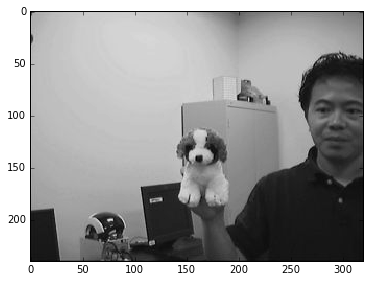

In [55]:
show(img)

In [57]:
idx

1

In [51]:
import tensorflow as tf
import numpy as np
import skimage
import skimage.io
import skimage.transform

show = skimage.io.imshow
%matplotlib inline


import matplotlib.pyplot as plt
import scipy.stats as st
import os
import sys

from vgg16 import vgg16
from sel_CNN import selCNN
from utils import extract_roi, gen_mask, img_with_bbox, print_prob



In [2]:
def porcess_img(img):
    """
    Porcessing image required by vgg16
    Returns:
        image of shape [224, 224, 3]
        [1, height, width, depth]
    """
    # load image
    img = img / 255.0
    assert (0 <= img).all() and (img <= 1.0).all()
    
    # conert to color image if its a grey one
    if len(img.shape) < 3:
        img = skimage.color.gray2rgb(img)
    assert len(img.shape) == 3
    
    # crop image from center
    short_edge = min(img.shape[:2])
    yy = int((img.shape[0] - short_edge) / 2)
    xx = int((img.shape[1] - short_edge) / 2)
    crop_img = img[yy : yy + short_edge, xx : xx + short_edge]

    # resize to 224, 224
    resized_img = skimage.transform.resize(crop_img, (224, 224))
    return resized_img.reshape((1, 224, 224, 3))

def _variable_on_cpu(name, shape, initializer):
	"""Helper to create a Variable stored on CPU memory.

	Args:
	  name: name of the variable
	  shape: list of ints
	  initializer: initializer for Variable

	Returns:
	  Variable Tensor
	"""
	dtype = tf.float32
	with tf.device('/cpu:0'):
		variable = tf.get_variable(name, shape, initializer=initializer, dtype=dtype)
	return variable

def variable_with_weight_decay(name, shape, stddev=1e-3, wd=None):
	"""Helper to create an initialized Variable with weight decay

	Args:
		name: name of the variable
		shape: list of ints
		stddev: float, standard deviation of a truncated Gaussian for initial value
		wd: add L2loss weight decay multiplied by this float. If None, weight decay 
				is not added to this variable

	Returns:
		Variable: Tensor
	"""
	dtype = tf.float32
	variable = _variable_on_cpu(
							name, 
							shape,
							initializer=tf.truncated_normal_initializer(stddev=stddev, dtype=dtype))
	if wd is not None:
		weight_decay = tf.mul(tf.nn.l2_loss(variable), wd, name='weight_loss')
		tf.add_to_collection('losses', weight_decay)
	return variable

def img_porcess(img):
    img = img.astype(float)
    # conert to color image if its a grey one
    if len(img.shape) < 3:
        img = skimage.color.gray2rgb(img)
        
    # Swap x,y order and subtract mean value
    mean_pix = [123.68, 116.779, 103.939] # BGR
    img = np.transpose(img, [1,0,2])
    img[:, :, 0] -= mean_pix[0]
    img[:, :, 1] -= mean_pix[1]
    img[:, :, 2] -= mean_pix[2]
    return img.reshape((1, 224, 224, 3))

In [19]:
sorted(os.listdir('data/Dog1/img/'))

'1350.jpg'

In [3]:
data_path = 'data/Dog1/'
img_path = os.path.join(data_path, 'img/0001.jpg')

# read bbox from file 
gt_fn = os.path.join(data_path, 'groundtruth_rect.txt')


f = open(gt_fn, 'r')
lines = f.readlines()

# gt_list is a list of list locations
gt_list = [[int(p) for p in i[:-1].split(',')] #('\t')] 
                   for i in lines]

# parper inputs 
gt_1 = gt_list[0]
img_origin = skimage.io.imread(img_path)

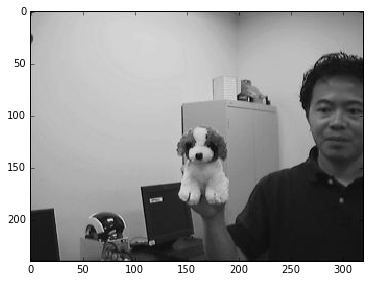

In [4]:
show(img_origin)

233 origin max
218 before bicubic resize
222 after bicubic resize
222 roi max


/home/xlws/repos/FCNT_TF/utils.py:173: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  print(img[y1-1:y2, x1-1:x2, :].max(), 'before bicubic resize')
/home/xlws/repos/FCNT_TF/utils.py:174: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  roi =  imresize(img[y1-1:y2, x1-1:x2, :], [roi_size, roi_size], interp='bicubic')


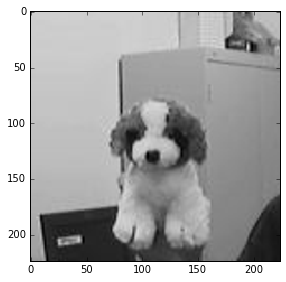

In [5]:

if len(img_origin.shape) < 3:
    img_origin = skimage.color.gray2rgb(img_origin)
assert len(img_origin.shape) == 3

w, h = gt_1[2:]
roi_size = 224
roi_scale = 2
dia = (w**2 + h**2)**0.5
scale = [dia / w, dia / h]
s1 = [roi_scale*scale[0], roi_scale*scale[1]]
roi, roi_pos, preimg, pad = extract_roi(img_origin, gt_1, [0,0], roi_size, s1)
#roi, _,_ =extract_roi_old(img_origin, gt_1, roi_size)
skimage.io.imshow(roi)

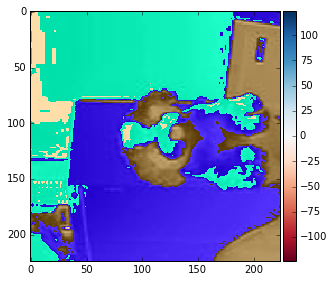

In [6]:
img_porcessed = img_porcess(roi)
show(img_porcessed[0,...])

In [7]:
fea_sz = (28, 28)
mask = gen_mask(img_origin.shape, fea_sz, roi_size, gt_1, [0,0], s1)

0.0013186425201 max of mask
0.0013186425201 origin max
0.0013186425201 before bicubic resize
255 after bicubic resize
255 roi max
(224, 224, 3)
248 max convas


/home/xlws/repos/FCNT_TF/utils.py:173: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  print(img[y1-1:y2, x1-1:x2, :].max(), 'before bicubic resize')
/home/xlws/repos/FCNT_TF/utils.py:174: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  roi =  imresize(img[y1-1:y2, x1-1:x2, :], [roi_size, roi_size], interp='bicubic')


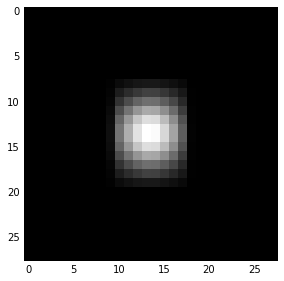

In [8]:
show(mask)

In [12]:
tf.reset_default_graph()

In [ ]:
img1.shape

In [10]:
graph = tf.get_default_graph()

In [13]:
[n.name for n in graph.as_graph_def().node]

['Placeholder',
 'preprocess/img_mean',
 'preprocess/sub',
 'conv1_1/truncated_normal/shape',
 'conv1_1/truncated_normal/mean',
 'conv1_1/truncated_normal/stddev',
 'conv1_1/truncated_normal/TruncatedNormal',
 'conv1_1/truncated_normal/mul',
 'conv1_1/truncated_normal',
 'conv1_1/weights',
 'conv1_1/weights/Assign',
 'conv1_1/weights/read',
 'conv1_1/Conv2D',
 'conv1_1/Const',
 'conv1_1/biases',
 'conv1_1/biases/Assign',
 'conv1_1/biases/read',
 'conv1_1/BiasAdd',
 'conv1_1',
 'conv1_2/truncated_normal/shape',
 'conv1_2/truncated_normal/mean',
 'conv1_2/truncated_normal/stddev',
 'conv1_2/truncated_normal/TruncatedNormal',
 'conv1_2/truncated_normal/mul',
 'conv1_2/truncated_normal',
 'conv1_2/weights',
 'conv1_2/weights/Assign',
 'conv1_2/weights/read',
 'conv1_2/Conv2D',
 'conv1_2/Const',
 'conv1_2/biases',
 'conv1_2/biases/Assign',
 'conv1_2/biases/read',
 'conv1_2/BiasAdd',
 'conv1_2',
 'pool1',
 'conv2_1/truncated_normal/shape',
 'conv2_1/truncated_normal/mean',
 'conv2_1/truncate

In [ ]:
img_tensor = graph.get_tensor_by_name('conv4_3:0')
img_tensor

In [14]:
from scipy.misc import imread, imresize
from imagenet_classes import class_names
sess = tf.Session()
imgs = tf.placeholder(tf.float32, [None, 224, 224, 3])
vgg = vgg16(imgs, 'vgg16_weights.npz', sess)

img1 = imread(img_path , mode='RGB')
img1 = imresize(img1, (224, 224))

graph = tf.get_default_graph()
img_tensor = graph.get_tensor_by_name('preprocess/sub:0')

img_porcessed, prob = sess.run([img_tensor, vgg.probs], feed_dict={vgg.imgs: [roi]}) # or use img porcessed
preds = (np.argsort(prob)[::-1])[0:5]
for p in preds:
    print( class_names[p], prob[p])

0 conv1_1_W (3, 3, 3, 64)
1 conv1_1_b (64,)
2 conv1_2_W (3, 3, 64, 64)
3 conv1_2_b (64,)
4 conv2_1_W (3, 3, 64, 128)
5 conv2_1_b (128,)
6 conv2_2_W (3, 3, 128, 128)
7 conv2_2_b (128,)
8 conv3_1_W (3, 3, 128, 256)
9 conv3_1_b (256,)
10 conv3_2_W (3, 3, 256, 256)
11 conv3_2_b (256,)
12 conv3_3_W (3, 3, 256, 256)
13 conv3_3_b (256,)
14 conv4_1_W (3, 3, 256, 512)
15 conv4_1_b (512,)
16 conv4_2_W (3, 3, 512, 512)
17 conv4_2_b (512,)
18 conv4_3_W (3, 3, 512, 512)
19 conv4_3_b (512,)
20 conv5_1_W (3, 3, 512, 512)
21 conv5_1_b (512,)
22 conv5_2_W (3, 3, 512, 512)
23 conv5_2_b (512,)
24 conv5_3_W (3, 3, 512, 512)
25 conv5_3_b (512,)
26 fc6_W (25088, 4096)
27 fc6_b (4096,)
28 fc7_W (4096, 4096)
29 fc7_b (4096,)
30 fc8_W (4096, 1000)
31 fc8_b (1000,)


TypeError: only integer arrays with one element can be converted to an index

In [15]:
show(img_porcessed[0])

ValueError: Images of type float must be between -1 and 1.

In [ ]:
vgg.imgs

In [ ]:
# visual conv layer
conv4_3 = graph.get_tensor_by_name('conv4_3:0')
conv5_3 = graph.get_tensor_by_name('conv5_3:0')
feed_dict={vgg.imgs: [roi]}
with tf.Session() as sess:
    res4, res5 = sess.run([conv4_3, conv5_3], feed_dict=feed_dict)
skimage.io.imshow(res4[0,:,:,0])

In [ ]:
isinstance(vgg.conv4_3, tf.Tensor)

In [ ]:

l_selcnn = selCNN('local', vgg.conv4_3)
pre_M_tensor = l_selcnn.pre_M
train_op, losses, lr, optimizer = l_selcnn.train(mask)


sess = tf.Session()
sess.run(tf.initialize_all_variables())




In [ ]:
max_itertimes = 1000
loss = []
imgs = []
lrt = []
for i in range(max_itertimes):
    # update weights
    _, total_loss, pre_M, lr_ = sess.run([train_op, losses, pre_M_tensor, lr], feed_dict=feed_dict)
    
    # visualize predicted heat map
    sys.stdout.flush()
    #print('loss: ',total_loss)
    loss.append(total_loss)
    lrt.append(lr_)
    if i % 50==0:
        imgs.append(pre_M)
    #plt.imshow(pre_M[0,:,:,0])
plt.plot(loss)

In [ ]:
loss[:10]

In [ ]:
plt.plot(lrt)

In [ ]:
for img in imgs:
    plt.figure()
    plt.imshow(img[0,:,:,0])

In [ ]:
loss[-1]

## Computes saiency maps

In [ ]:
# S = -GF + 0.5 * H * F**2
# where G is partial derivative of L(sel-CNN) with respect to F feature
# maps of vgg. H is a diagnal part of the Hessian matrix, which can be 
# computed by back probpagation twice with respect to the feature maps.



In [ ]:
[n.name for n in tf.get_default_graph().as_graph_def().node]

In [ ]:
F = vgg.graph.get_tensor_by_name('vgg16/conv4_3/filter:0')
F = tf.assign(F, tf.Variable(F, trainable=False))
G = optimizer.compute_gradients(losses, var_list=[F])

In [ ]:
tt = tf.Variable(F, trainable=False)

In [ ]:
g= tf.get_default_graph()

In [ ]:
[n.name for n in g.get_collection('variables')]

In [ ]:
F.

In [ ]:
F = tf.assign(F, tf.Variable(F, trainable=False))

In [ ]:
G = optimizer.compute_gradients(losses, var_list=[F])